In [1]:
import os
import numpy as np
import torch
from PIL import Image
import xml.dom.minidom as xmldom
from torchvision import transforms as T
import cv2 as cv
import matplotlib.patches as patches

def parse_xml(fn):
    xml_file = xmldom.parse(fn)
    eles = xml_file.documentElement
    xmin = eles.getElementsByTagName("xmin")[0].firstChild.data
    xmax = eles.getElementsByTagName("xmax")[0].firstChild.data
    ymin = eles.getElementsByTagName("ymin")[0].firstChild.data
    ymax = eles.getElementsByTagName("ymax")[0].firstChild.data
    return xmin, xmax, ymin, ymax

class MaskDataset(object):
    def __init__(self, pic_root, mask_root ,transforms):
        
        self.pic_root = pic_root
        self.mask_root = mask_root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(pic_root, "image_mask/"))))
        self.loc = list(sorted(os.listdir(os.path.join(mask_root, "location/"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.pic_root, "image_mask", self.imgs[idx])
        loc_path = os.path.join(self.mask_root, "location", self.loc[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        
        Image_array = np.array(img)
        curve_x =  Image_array.shape[1]/256.0
        curve_y =  Image_array.shape[0]/256.0

        xmin,xmax,ymin,ymax= parse_xml(loc_path)
        
#         xmin = float(xmin)*curve_x
#         xmax = float(xmax)*curve_x
#         ymin = float(ymin)*curve_y
#         ymax = float(ymax)*curve_y
        xmin = float(xmin)
        xmax = float(xmax)
        ymin = float(ymin)
        ymax = float(ymax)
        
        boxes = []
        boxes.append([xmin,ymin,xmax,ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones(1,dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
    
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
image,target=dataset.__getitem__(0)
print(image)

print(target)
plt.imshow(image.detach().numpy().transpose(1,2,0))
ax = plt.gca()
for x1,y1,x2,y2 in target['boxes']:
        print("boxes info",x1, y1, x2, y2)
        rect = patches.Rectangle((np.int32(x1), np.int32(y1)),(np.int32(x2)-np.int32(x1)),(np.int32(y2)-np.int32(y1)), 
                    linewidth=2,
                    edgecolor='cyan',
                    fill = False)
        ax.add_patch(rect)
plt.show()

NameError: name 'dataset' is not defined

In [2]:
def collate_fn(batch):
    return list(zip(*batch))
path = 'C:/Users/msi/Desktop/Final/image/'
transforms=T.Compose([
#                 T.Resize((256,256),Image.BICUBIC),
                T.ToTensor()
            ])
dataset=MaskDataset(path,path,transforms)

image,target=dataset.__getitem__(0)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True,num_workers=0,collate_fn=collate_fn)


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:/Users/msi/Desktop/Final/image/image_mask/'

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 192,256),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.1)

    # let's train it for 10 epochs
num_epochs = 20

NameError: name 'params' is not defined

In [6]:
from tqdm import tqdm

model.to(device)
model.train()
for epoch in tqdm(range(num_epochs)):
    for images,targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]E:\Anaconda3\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
100%|██████████| 20/20 [10:18<00:00, 30.94s/it]


[{'boxes': tensor([[132.0217, 182.0335, 447.8164, 379.2875]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0', grad_fn=<IndexBackward>)}]
[tensor([[[0.5569, 0.5569, 0.5608,  ..., 0.3804, 0.3765, 0.3725],
         [0.5569, 0.5569, 0.5608,  ..., 0.3765, 0.3725, 0.3725],
         [0.5608, 0.5608, 0.5608,  ..., 0.3843, 0.3804, 0.3765],
         ...,
         [0.7569, 0.7882, 0.8118,  ..., 0.3451, 0.3529, 0.3608],
         [0.7451, 0.7765, 0.8000,  ..., 0.3490, 0.3569, 0.3647],
         [0.7373, 0.7686, 0.7882,  ..., 0.3529, 0.3608, 0.3686]],

        [[0.4980, 0.4980, 0.5020,  ..., 0.3608, 0.3569, 0.3529],
         [0.4980, 0.4980, 0.5020,  ..., 0.3569, 0.3529, 0.3529],
         [0.5020, 0.5020, 0.5020,  ..., 0.3647, 0.3608, 0.3569],
         ...,
         [0.7686, 0.8000, 0.8235,  ..., 0.2627, 0.2706, 0.2784],
         [0.7569, 0.7882, 0.8118,  ..., 0.2667, 0.2745, 0.2824],
         [0.7490, 0.7804, 0.800

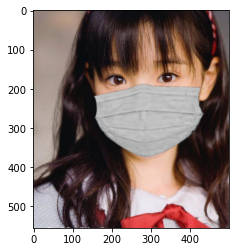

In [13]:
model.eval()
images,targets = dataset.__getitem__(5)
images = [images.to(device)]
output=model(images)
print(output)
print(images)
image = images[0].cpu().detach().numpy().transpose(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [10]:
def checkimg(image,output):
    boxes = output[0]['boxes'].cpu().detach().numpy()
    scores = output[0]['scores'].cpu().detach().numpy()
    labels = output[0]['labels'].cpu().detach().numpy()
    index = 0
    plt.imshow(image)
    ax = plt.gca()
    for x1,y1,x2,y2 in boxes:
        if scores[index]>0.5:
            print("boxes info",x1, y1, x2, y2)
            rect = patches.Rectangle((np.int32(x1), np.int32(y1)),(np.int32(x2)-np.int32(x1)),(np.int32(y2)-np.int32(y1)), 
                     linewidth=2,
                     edgecolor='cyan',
                     fill = False)
            ax.add_patch(rect)
        index+=1
    plt.show()

boxes info 132.02173 182.03351 447.8164 379.28748


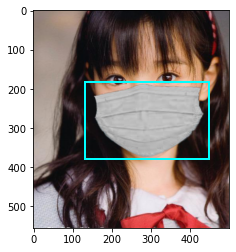

In [17]:
checkimg(image,output)

In [7]:
# images,targets = next(iter(data_loader))
# print(images)
# print(targets)
# from tqdm import tqdm
# model.to(device)
# model.train()
# for epoch in tqdm(range(num_epochs)):
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#     loss_dict = model(images, targets)
#     losses = sum(loss for loss in loss_dict.values())
#     print(losses)
        
#     optimizer.zero_grad()
#     losses.backward()
#     optimizer.step()

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.1451, 0.1647, 0.1804,  ..., 0.1882, 0.1843, 0.1843],
         [0.1451, 0.1647, 0.1804,  ..., 0.1922, 0.1922, 0.1922],
         [0.1451, 0.1647, 0.1804,  ..., 0.2039, 0.2039, 0.2039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.1725, 0.1686, 0.1647,  ..., 0.1765, 0.1765, 0.1725],
         [0.1725, 0.1686, 0.1647,  ..., 0.1647, 0.1647, 0.1608],
         [0.1725, 0.1686, 0.1647,  ..., 0.1608, 0.1608, 0.1608]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0

In [12]:
model.eval()
path2 = 'F:/Data/EE599Final/test/n001131/02_0390_01.jpg'
transforms2=T.Compose([
                T.Resize((256,256),Image.BICUBIC),
                T.ToTensor()
            ])
img = Image.open(path2).convert("RGB")
img =transforms2(img)
img = [img.to(device)]
output=model(img)
print(output)
print(img)
img = img[0].cpu().detach().numpy().transpose(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
checkimg(img,output)

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Data/EE599Final/test/n001131/02_0390_01.jpg'

In [40]:
torch.save(model.state_dict(),'resnet50+mobilev2.pth')

In [4]:
model.load_state_dict(torch.load('resnet50+mobilev2.pth'))

<All keys matched successfully>

[{'boxes': tensor([[ 69.1861, 106.6467, 188.2500, 252.7880]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0', grad_fn=<IndexBackward>)}]
[tensor([[[0.3804, 0.3725, 0.3647,  ..., 0.1255, 0.1255, 0.1255],
         [0.3843, 0.3765, 0.3647,  ..., 0.1294, 0.1255, 0.1255],
         [0.3725, 0.3686, 0.3569,  ..., 0.1294, 0.1294, 0.1294],
         ...,
         [0.4941, 0.4824, 0.4667,  ..., 0.1020, 0.0902, 0.0941],
         [0.4863, 0.4863, 0.4745,  ..., 0.0667, 0.0784, 0.0745],
         [0.4863, 0.4863, 0.4745,  ..., 0.0392, 0.0588, 0.0588]],

        [[0.3020, 0.2941, 0.2863,  ..., 0.1137, 0.1137, 0.1137],
         [0.3020, 0.2980, 0.2863,  ..., 0.1176, 0.1137, 0.1137],
         [0.3059, 0.3020, 0.2902,  ..., 0.1176, 0.1176, 0.1176],
         ...,
         [0.5020, 0.4941, 0.4784,  ..., 0.1137, 0.0941, 0.0941],
         [0.4902, 0.4902, 0.4784,  ..., 0.0784, 0.0902, 0.0863],
         [0.4902, 0.4902, 0.478

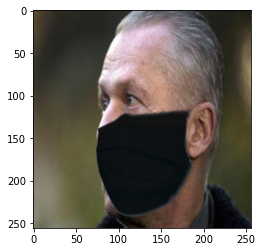

boxes info 69.18612 106.64671 188.25003 252.78796


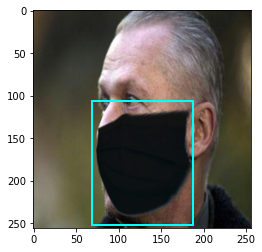

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
path2 = 'F:/Data/EE599Final/train/n001131/02_0390_01.jpg'
transforms2=T.Compose([
                T.Resize((256,256),Image.BICUBIC),
                T.ToTensor()
            ])
img = Image.open(path2).convert("RGB")
img =transforms2(img)
img = [img.to(device)]
output=model(img)
print(output)
print(img)
img = img[0].cpu().detach().numpy().transpose(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
checkimg(img,output)